# Experiments on the threshold value of TVLA

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns

from src.tools.cache import cache_np
from src.tools.file import store_plt
from src.tools.plotter import init_plots, store_sns
from src.tvla.t import make_t_test
from numpy.random import default_rng

PRNG = default_rng()
init_plots()

In [2]:
VARIANCE = 2.2 # Modelled to the variance of the ASCAD database

In [3]:
def gen_trace(num_traces, trace_length, var=VARIANCE, prng=PRNG):
    """
    Generates a trace set of given size and number of sample points using a normal distribution.
    """
    norm = prng.standard_normal((num_traces, trace_length))
    return (norm * var).astype(np.int8)

def get_mv(traces):
    return traces.mean(axis=0), traces.var(axis=0)

In [4]:
def tvla(trace_length):
    # DoF simplified, as in the paper of Schneider & Moradi (2016, page 87)
    num_traces = 1000

    test = make_t_test(num_traces, num_traces)
    mv_a = get_mv(gen_trace(num_traces, trace_length))
    mv_b = get_mv(gen_trace(num_traces, trace_length))

    return test(*mv_a, *mv_b)

In [5]:
NUM_TIMES = 1000

def min_ps(graph_ix):
    threshold_p = 10 ** -5
    threshold_t = 4.5
    fpr = np.zeros((len(graph_ix), 2, 2))

    for ix, trace_length in enumerate(graph_ix):
        # Slower implementation, easier on the eyes of the reader.
        for _ in tqdm(range(NUM_TIMES)):
            t, p = tvla(int(trace_length))
            abs_t = np.abs(t)

            fpr[ix, 0] += np.array([max(abs_t) > threshold_t, min(p) < threshold_p], dtype=int)
            fpr[ix, 1] += np.array([np.sum(abs_t > threshold_t), np.sum(p < threshold_p)])

    return fpr

MAX_EXP = 5
INDEX = np.logspace(0, MAX_EXP, MAX_EXP * 3 + 1)
FPR = cache_np("fpr", min_ps, INDEX)

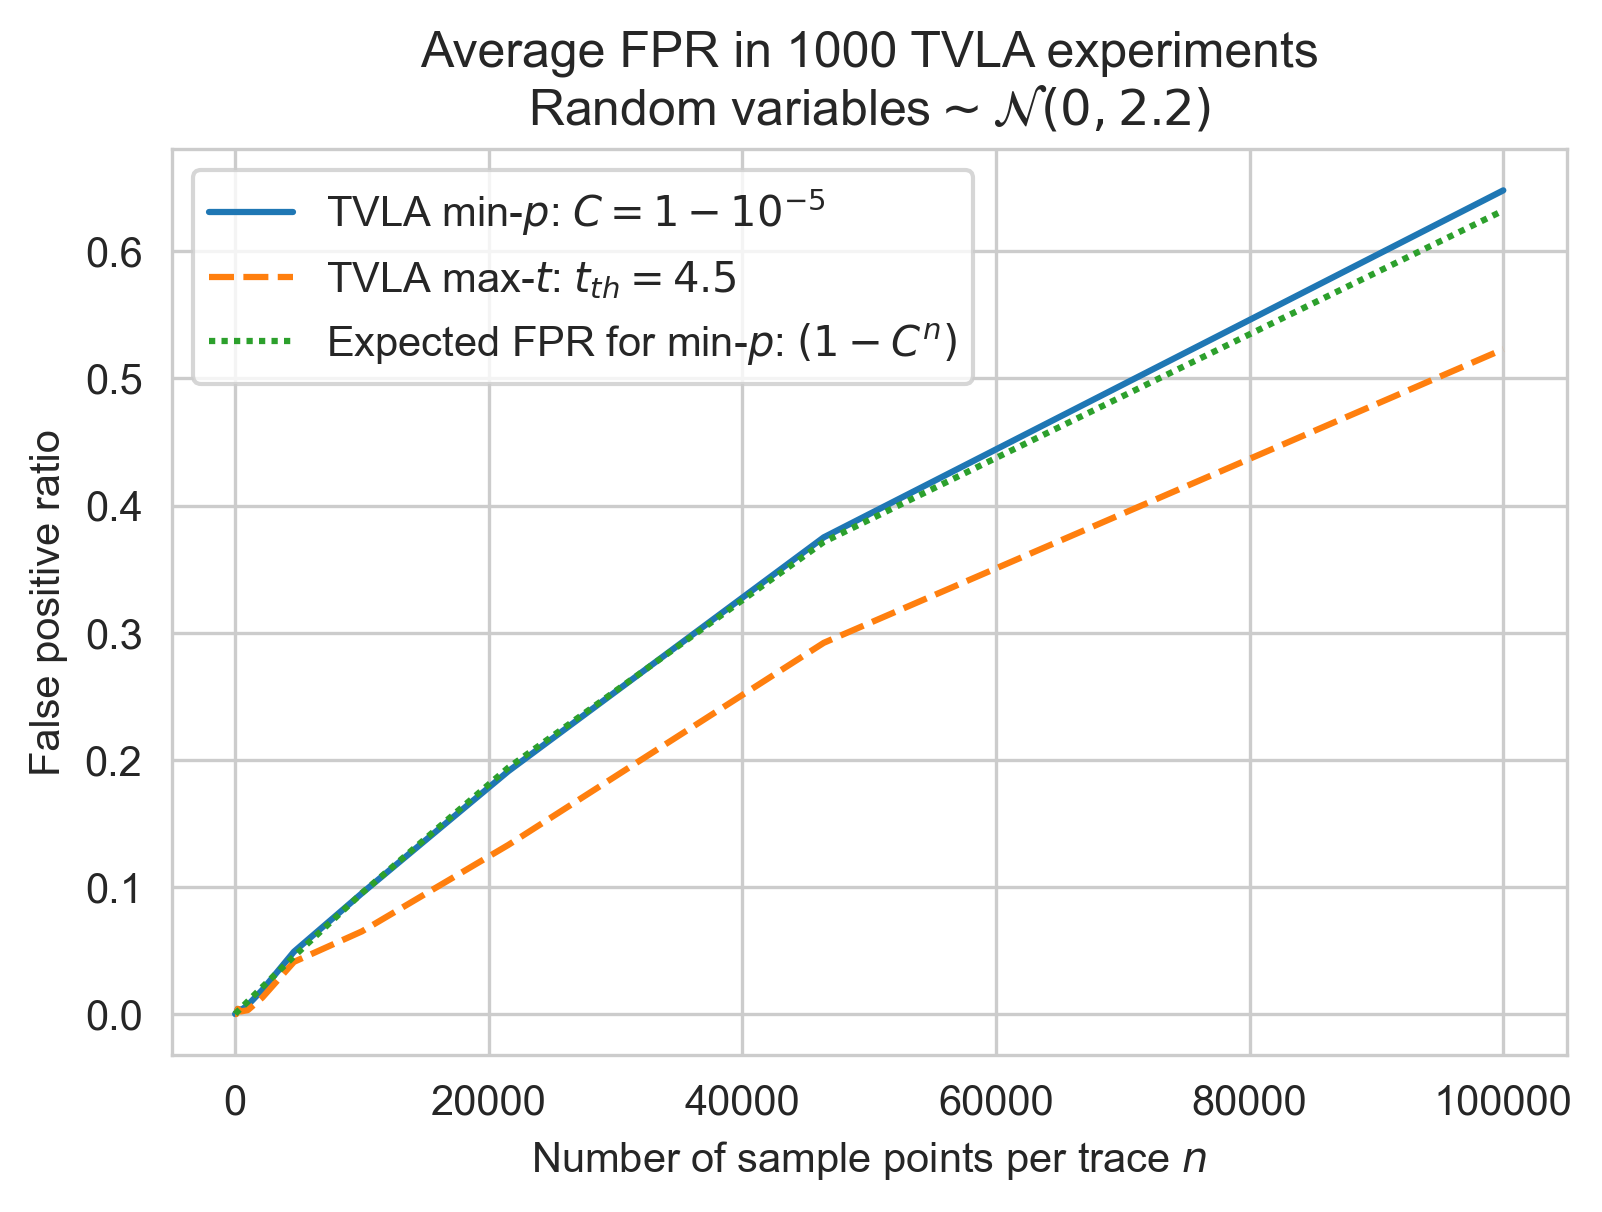

In [6]:
# "Threshold: $|t| > 4.5$": FPR[:, 0, 0] / NUM_TIMES,

DATA = {
    "TVLA min-$p$: $C = 1 - 10^{-5}$": FPR[:, 0, 1] / NUM_TIMES,
    "TVLA max-$t$: $t_{th} = 4.5$": FPR[:, 0, 0] / NUM_TIMES,
    "Expected FPR for min-$p$: $(1 - C^{n})$": (1 - (1 - 10 ** -5) ** INDEX),
}

G = sns.lineplot(data=pd.DataFrame(DATA).set_index(INDEX.astype(int)))
G.set(xlabel="Number of sample points per trace $n$",
      ylabel="False positive ratio",
      title="Average FPR in 1000 TVLA experiments\nRandom variables$\\sim \mathcal{N}(0, 2.2)$")

store_sns(G, "fpr_min_p")

In [7]:
pd.DataFrame(DATA).set_index(INDEX.astype(int))

,TVLA min-$p$: $C = 1 - 10^{-5}$,TVLA max-$t$: $t_{th} = 4.5$,Expected FPR for min-$p$: $(1 - C^{n})$
1,0.000,0.000,0.000010
2,0.000,0.000,0.000022
4,0.000,0.000,0.000046
10,0.000,0.000,0.000100
21,0.000,0.000,0.000215
46,0.000,0.000,0.000464
100,0.001,0.000,0.001000
215,0.004,0.004,0.002152
464,0.003,0.002,0.004631
1000,0.007,0.003,0.009950


In [8]:
pd.DataFrame(DATA).set_index(INDEX.astype(int)).to_latex(
    caption="False positive rate, TVLA min-$p$, random vs. random. Random variables$\\sim \mathcal{N}(0, 2.2)$",
    label="tab:fpr-min-p"
)

'\\begin{table}\n\\centering\n\\caption{False positive rate, TVLA min-$p$, random vs. random. Random variables$\\sim \\mathcal{N}(0, 2.2)$}\n\\label{tab:fpr-min-p}\n\\begin{tabular}{lrrr}\n\\toprule\n{} &  TVLA min-\\$p\\$: \\$C = 1 - 10\\textasciicircum \\{-5\\}\\$ &  TVLA max-\\$t\\$: \\$t\\_\\{th\\} = 4.5\\$ &  Expected FPR for min-\\$p\\$: \\$(1 - C\\textasciicircum \\{n\\})\\$ \\\\\n\\midrule\n1      &                            0.000 &                         0.000 &                                 0.000010 \\\\\n2      &                            0.000 &                         0.000 &                                 0.000022 \\\\\n4      &                            0.000 &                         0.000 &                                 0.000046 \\\\\n10     &                            0.000 &                         0.000 &                                 0.000100 \\\\\n21     &                            0.000 &                         0.000 &                               